# Evaluating the degree of overlap between equivalent pathways in KEGG, Reactome, and WikiPathways

This notebook outlines the process of evaluating the overlap between the equivalent representations in the three databases. First, we calculate a similarity index by using a variation of the Szymkiewicz–Simpson/Overlap coefficient (Equation 1) calculated for the shared amount of molecular nodes in the graph. This variation sums the three coefficients obtained for each individual pairwise comparison to generate the similarity index.
Second, Venn diagrams illustrates the degree of overlap in a more visual way.

$$overlap(X,Y))=\frac{\left | X \cap  Y \right |}{min(\left |X  \right |,\left |Y  \right |))}$$
<center> Equation 1. Szymkiewicz–Simpson/Overlap coefficient </center>

# Summary of the similarity evaluation between equivalent pathways 

| Pathway Name | Pathway Similarity Index | Molecular Entities Present in all Three Equivalent Pathways | Comments About the Results |
| --- | --- | --- |
| Cell Cycle | 0.70 | ANAPC1, ANAPC10, ANAPC11, ANAPC2, ANAPC4, ANAPC5, ANAPC7, ATM, CCNA1, CCNA2, CCNB1, CCNB2, CCND1, CCNE1, CDC16, CDC20, CDC23, CDC25A, CDC27, CDK1, CDK2, CDK4, CDKN1A, CHEK1, EP300, FZR1, MAD1L1, ORC1, ORC2, ORC3, ORC4, ORC5, ORC6, PLK1, RAD21, RB1, SMC1A, SMC1B, SMC3, STAG1, STAG2, TP53 | All three representations converge to a largely shared set of molecular players that include cyclins (e.g., CDK1, CDK2, CDK4, CDKN1A) and other cell cycle regulators (e.g., ATM, P53, FZR1) |
| Toll-like Receptor Signaling Pathway | 0.62 | CASP8, CD14, CHUK, FADD, IKBKB, IRAK1, IRAK4, IRF7, MAP3K7, MYD88, TLR2, TLR3, TLR4, TLR9, TRAF3, TRAF6 | Members from the toll like receptor family (e.g., TLR2, TLR3, TLR4, TLR9) and TRAFs (e.g. TRAF3, TRAF6) utilized by TLRs for signaling are shared amongst all equivalent representations of this pathway | 
| Target Of Rapamycin (TOR) Signaling | 0.58 | EIF4EBP1, MLST8, MTOR, RHEB, RPS6KB1, RPTOR, TSC1, TSC2 | Major pathway players include MTOR, RPTOR, MLST8 and RHEB | 
| Hedgehog Signaling Pathway | 0.56 | GRK2, SMO, SUFU | The conserved SMO protein is found in all three representations as is the pathway regulator SUFU. More pronounced overlap can be seen in KEGG and Reactome  | 
| Apoptosis | 0.44 | APAF1, BAD, BAX, BID, CASP3, CASP7, CASP8, CASP9, CYCS, DFFA, FAS, FASLG, TP53 | The common apototic elements (e.g., caspase family, BAX/BAD) are shared across the three equivalent pathways | 
| IL17 signaling pathway | 0.42 | - | Reactome is completely embedded in the WikiPathways representation. However, there is no overlap between Reactome and KEGG | 
| PI3K-Akt Signaling Pathway | 0.42 | MDM2, PTEN, TP53, TSC2 | PTEN and TP53 are among the common players in this pathway |
| Wnt Signaling Pathway | 0.40 |AXIN1, AXIN2, CTBP1, CTNNB1, DVL1, DVL2, GSK3B, LRP6, MAP3K7, MYC, NLK, PRKCA| Well-known interacting molecules of the beta-catenin complex are present (e.g., AXIN1, AXIN2, DVL2, GSK3B) | 
| MAPK Signaling Pathway | 0.40 | BRAF, JUN, RAF1 | Both serine/threonine kinases (i.e., BRAF/RAF1) as well as the proto-oncogene JUN, or P39, are present in all representations | 
| B Cell Receptor Signaling Pathway | 0.37 | BLNK, BTK, CARD11, CD19, CD22, DAPP1, MALT1, PIK3AP1, PRKCB, PTPN6, SYK, VAV1 | Protein kinases (e.g., BTK, SYK) and adaptor proteins (e.g., BLNK, CD19, PIK3AP1) involved in the pathway can be found in the three equivalent representations  |
| Notch Signaling Pathway | 0.29 | EP300, SNW1 | Co-activators EP300 and SNW1 involved in notch signaling are common to all three. A greater degree of overlap exists in KEGG and WikiPathways representations, including NOTCH and HES proteins | 
| DNA Replication | 0.28 | -  | Both KEGG and WikiPathways have cartoon representations of the pathway and lack mechanistic information | 
| Prolactin Signaling Pathway | 0.28 | JAK2, PRLR | The prolactin receptor (i.e. PRLR) and the kinase JAK2 are common elements in all equivalent representations of this pathway | 
| TGF-beta Signaling Pathway | 0.26 | RHOA, SMAD2, SMAD3, SMAD4, SMAD7, SMURF1, SMURF2, TGFBR1, TGFBR2, ZFYVE16 | Protein kinases (i.e., TGFBR1, TGFBR2) and transcription factors (i.e., SMAD2, SMAD3, SMAD4, SMAD7) are among the common players in this pathway |
| Thyroxine (Thyroid Hormone) Production | 0.20 | -  | KEGG and WikiPathways have a minimal amount of overlap with cause or association relations; Reactome has exclusively reaction type edges thus no overlap with KEGG and WikiPathways | 
| Sphingolipid Metabolism | 0.16 | - | Surprisingly, while KEGG shows some overlap with Reactome and WikiPathways, there is no overlap between the Reactome and WikiPathways representations | 
| Mismatch repair | 0.08 | - | WikiPathways RDF representation is empty. No edges present in KGML file (only BEL component membership edges generated)| 
| Non-homologous end joining | 0 | -  | Both KEGG and WikiPathways contain cartoon representations of the pathway and lack mechanistic information | | 


Table 1. Equivalent pathways ordered by similarity (column 2). Common core of nodes is listed in column 3. Notes explaining the results are presented in column 4.

In [1]:
import os
from collections import Iterable, defaultdict
import warnings
import pandas as pd
import itertools as itt
import operator

import matplotlib.pyplot as plt
from matplotlib_venn import venn3 

from pybel import from_pickle, union
from pybel_tools import utils
from pybel.struct.mutation import remove_biological_processes, remove_filtered_nodes, collapse_to_genes
from pybel.constants import REACTION, COMPLEX, COMPOSITE
from pybel.struct.filters.node_predicate_builders import function_inclusion_filter_builder

from pathme.constants import REACTOME_BEL, KEGG_BEL, WIKIPATHWAYS_BEL
from pathme.utils import get_files_in_folder

from pathme_viewer.graph_utils import add_annotation_key, add_annotation_value

from bio2bel_kegg import Manager as KeggManager
from bio2bel_reactome import Manager as ReactomeManager
from bio2bel_wikipathways import Manager as WikipathwaysManager

In [2]:
%matplotlib inline

In [3]:
# Remove Warnings Venn Diagram
warnings.filterwarnings('ignore')

In [4]:
# Initiate WikiPathways Manager
wikipathways_manager = WikipathwaysManager()
# Initiate Reactome Manager
reactome_manager = ReactomeManager()
# Initiate KEGG Manager
kegg_manager = KeggManager()

In [5]:
# Equivalent pathway IDs (ordered)
reactome_ids = ['R-HSA-5358508','R-HSA-209968','R-HSA-195721','R-HSA-5683057','R-HSA-71336','R-HSA-1257604','R-HSA-168898','R-HSA-983705','R-HSA-157118','R-HSA-109581','R-HSA-428157','R-HSA-5358351','R-HSA-71403','R-HSA-69306','R-HSA-5693571','R-HSA-1640170','R-HSA-9006936','R-HSA-165159','R-HSA-448424','R-HSA-74182','R-HSA-1170546']               
kegg_ids = ['hsa03430','hsa04918','hsa04310','hsa04010','hsa00030','hsa04151','hsa04620','hsa04662','hsa04330','hsa04210','hsa00600','hsa04340','hsa00020','hsa03030','hsa03450','hsa04110','hsa04350','hsa04150','hsa04657','hsa00072','hsa04917']
wikipathways_ids = ['WP531','WP1981','WP363','WP382','WP134','WP4172','WP75','WP23','WP61','WP254','WP1422','WP47','WP78','WP466','WP438','WP179','WP366','WP1471','WP2112','WP311','WP2037']

# Reactome pathways not contained in Reactome RDF file
REACTOME_BLACK_LIST = ['R-HSA-2025928','R-HSA-9604323', 'R-HSA-9013700','R-HSA-9017802','R-HSA-168927', 'R-HSA-9014325', 'R-HSA-9013508', 'R-HSA-9013973', 'R-HSA-9013957', 'R-HSA-9013695']

Methods used in this notebook

In [6]:
def flatten(l):
    for el in l:
        if isinstance(el, Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el
            

def get_all_pathway_children_by_id(manager, reactome_id):
    
    pathway = manager.get_pathway_by_id(reactome_id)

    if not pathway.children:
        return pathway.reactome_id
    
    children = []
    
    for child in pathway.children:

        children.append(get_all_pathway_children_by_id(manager, child.reactome_id))
    
    return children

def add_pathway_annotations(graph, resource_name, pathway_id):
    
    graph.annotation_pattern['Database'] = '.*'

    add_annotation_key(graph)

    add_annotation_value(graph, 'Database', resource_name)
    
    return graph

def get_bel_graph(resource_name, pathway_id):
    
    if resource_name == 'reactome':
        
        pickle_path = os.path.join(REACTOME_BEL, pathway_id + '.pickle')
        
    elif resource_name == 'kegg':
        
        pickle_path = os.path.join(KEGG_BEL, pathway_id + '_unflatten.pickle')
 
    elif resource_name == 'wikipathways':
        
        pickle_path = os.path.join(WIKIPATHWAYS_BEL, pathway_id + '.pickle')
    
    # Get BEL graph from pickle 
    bel_graph = from_pickle(pickle_path)
    
    return add_pathway_annotations(bel_graph, resource_name, pathway_id)

def calculate_jaccard(set_1, set_2):
    """Calculate jaccard similarity between two sets.
    
    :param set set_1: set 1
    :param set set_2: set 2
    :returns similarity
    :rtype: float
    """
    intersection = len(set_1.intersection(set_2))
    smaller_set = min(len(set_1), len(set_2))
            
    return intersection/smaller_set

def calculate_pathway_similarity(set_1, set_2, set_3):
    """Calculate pathway similarity between three sets.
    
    :param set set_1: set 1
    :param set set_2: set 2
    :param set set_3: set 3
    :returns similarity
    :rtype: float
    """
    scores = [
        calculate_jaccard(set_one, set_two)
        for set_one, set_two in itt.combinations([set_1, set_2, set_3], 2)
        if set_one and set_two # Ensure non-empty sets
    ]
    
    return sum(scores)

def prepare_venn_diagram(pathway_name,kegg_set, reactome_set, wikipathways_set):

    # Nodes present in KEGG but not in Reactome, nor in WikiPathways
    unique_kegg = len(kegg_set.difference(reactome_set).difference(wikipathways_set))

    # Nodes present in Reactome but not in KEGG, nor in WikiPathways
    unique_reactome = len(reactome_set.difference(kegg_set).difference(wikipathways_set))

    # Nodes present in WikiPathways but not in KEGG, nor in Reactome
    unique_wikipathways = len(wikipathways_set.difference(kegg_set).difference(reactome_set))

    # Nodes common between KEGG and Reactome but not in WikiPathways
    common_kegg_reactome = len(kegg_set.intersection(reactome_set).difference(wikipathways_set))

    # Nodes common between KEGG and WikiPathways but not in Reactome
    common_kegg_wikipathways = len(kegg_set.intersection(wikipathways_set).difference(reactome_set))

    # Nodes common between Reactome and WikiPathways but not in KEGG
    common_reactome_wikipathways = len(reactome_set.intersection(wikipathways_set).difference(kegg_set))

    # Nodes common between KEGG and Reactome and WikiPathways 
    common_kegg_reactome_wikipathways = len(kegg_set.intersection(reactome_set).intersection(wikipathways_set))

    return (
        unique_kegg, 
        unique_reactome,
        common_kegg_reactome, 
        unique_wikipathways, 
        common_kegg_wikipathways,
        common_reactome_wikipathways, 
        common_kegg_reactome_wikipathways
       )

def plot_venn_diagram(pathway_name, data):

    plt.figure(figsize=(10, 10))
    diagram = venn3(
        subsets = data, 
        set_labels = ("KEGG", "Reactome", "WikiPathways")
    )
    
    for text in diagram.set_labels:
        if text:
            text.set_fontsize(28)
    for text in diagram.subset_labels:
        if text:
            text.set_fontsize(16)
    
    plt.title(pathway_name, fontsize=30)

    if diagram.get_patch_by_id('001'):
        diagram.get_patch_by_id('001').set_color('#5bc0de') #WikiPathways
        diagram.get_patch_by_id('001').set_alpha(1.0)
    
    if diagram.get_patch_by_id('010'):
        diagram.get_patch_by_id('010').set_color('#df3f18') # Reactome
        diagram.get_patch_by_id('010').set_alpha(1.0)
    
    if diagram.get_patch_by_id('011'):
        diagram.get_patch_by_id('011').set_color('#9d807b') # Wiki - Reactome
        diagram.get_patch_by_id('011').set_alpha(1.0)
    
    if diagram.get_patch_by_id('100'):
        diagram.get_patch_by_id('100').set_color('#5cb85c') # KEGG
        diagram.get_patch_by_id('100').set_alpha(1.0)
    
    if diagram.get_patch_by_id('110'):
        diagram.get_patch_by_id('110').set_color('#f3ac1f') # KEGG U Reactome
        diagram.get_patch_by_id('110').set_alpha(0.8)
    
    if diagram.get_patch_by_id('111'):
        diagram.get_patch_by_id('111').set_color('#ffffff') # Middle
        diagram.get_patch_by_id('111').set_alpha(1.0)
        
    if diagram.get_patch_by_id('101'):
        diagram.get_patch_by_id('101').set_color('#a2ded0') # KEGG - Wiki
        diagram.get_patch_by_id('101').set_alpha(1.0)
    
    plt.show()
    

Create a dictionary for Reactome pathways with children

In [7]:
parent_to_child = dict()

for reactome_id in reactome_ids:
    
    all_children = get_all_pathway_children_by_id(reactome_manager, reactome_id)

    if isinstance(all_children, str):
        continue
        
    flattened_children = flatten(all_children)
    parent_to_child[reactome_id] = [pathway for pathway in flattened_children]

Get the merged network for every equivalent pathway

In [8]:
merged_pathways = defaultdict(list)

for counter, reactome_id in enumerate(reactome_ids):
    
    reactome_graphs = []

    kegg_bel_graph = get_bel_graph('kegg', kegg_ids[counter])

    wikipathways_bel_graph = get_bel_graph('wikipathways', wikipathways_ids[counter])

    pathway_name = wikipathways_manager.get_pathway_by_id(wikipathways_ids[counter]) 
        
    # Check if reactome ID is in black list 
    if reactome_id in REACTOME_BLACK_LIST:
        continue
    
    # If Reactome parent pathway has children, get merged graph of children
    if reactome_id in parent_to_child:            
            
        pathway_children = parent_to_child[reactome_id]

        for child in pathway_children:
            if child not in REACTOME_BLACK_LIST:

                reactome_bel_graph = get_bel_graph('reactome', child)
                reactome_graphs.append(reactome_bel_graph)
                
    # Get Reactome parent pathway graph
    else:
        reactome_graphs.append(get_bel_graph('reactome', reactome_id))
    
    # Get union of all bel graphs for each equivalent pathway
    merged_graph = union([kegg_bel_graph, wikipathways_bel_graph, union(reactome_graphs)])
    
    # Collapse all protein, RNA, miRNA nodes to gene nodes
    collapse_to_genes(merged_graph)
    
    merged_pathways[str(pathway_name)] = merged_graph


## Visualizing the overlaps across equivalent pathways

In [9]:
# Dictionary of pathway names to venn diagram circle sizes to plot
venn_diagram_dict = {}
pathway_similarity = {}

for pathway_name, merged_graph in merged_pathways.items():
    
    node_set_kegg = set()
    node_set_reactome = set()
    node_set_wikipathways = set()

    # For each resource, add nodes with edges to resource node set if node is gene, protein, RNA, miRNA or chemical
    for u, v, k, data in merged_graph.edges(keys=True, data=True):
        
        info = merged_graph[u][v][k]
        
        if info['annotations']['Database'].get('kegg'):
            
            if u.function not in {'BiologicalProcess', 'Complex', 'Composite', 'Reaction'}:
                node_set_kegg.add(u)

            if v.function not in {'BiologicalProcess', 'Complex', 'Composite', 'Reaction'}:
                node_set_kegg.add(v)
         
        if info['annotations']['Database'].get('reactome'):
        
            if u.function not in {'BiologicalProcess', 'Complex', 'Composite', 'Reaction'}:
                node_set_reactome.add(u)
                
            if v.function not in {'BiologicalProcess', 'Complex', 'Composite', 'Reaction'}:
                node_set_reactome.add(v)
         
        if info['annotations']['Database'].get('wikipathways'):
        
            if u.function not in {'BiologicalProcess', 'Complex', 'Composite', 'Reaction'}:
                node_set_wikipathways.add(u)
                
            if v.function not in {'BiologicalProcess', 'Complex', 'Composite', 'Reaction'}:
                node_set_wikipathways.add(v)
            
    venn_diagram_dict[pathway_name] = prepare_venn_diagram(
        pathway_name,
        node_set_kegg,
        node_set_reactome,
        node_set_wikipathways
    )
    
    pathway_similarity[pathway_name] = calculate_pathway_similarity(
        node_set_kegg,
        node_set_reactome,
        node_set_wikipathways
    )

### Similarity results

In [10]:
for pathway, score in sorted(pathway_similarity.items(), key=operator.itemgetter(1),reverse=True):
    print("'{}' has a pathway similarity index of: {}".format(pathway, round(score, 2)))

'Cell Cycle' has a pathway similarity index of: 2.1
'Toll-like Receptor Signaling Pathway' has a pathway similarity index of: 1.85
'Target Of Rapamycin (TOR) Signaling' has a pathway similarity index of: 1.75
'Hedgehog Signaling Pathway' has a pathway similarity index of: 1.67
'Apoptosis' has a pathway similarity index of: 1.31
'IL17 signaling pathway' has a pathway similarity index of: 1.27
'PI3K-Akt Signaling Pathway' has a pathway similarity index of: 1.25
'Wnt Signaling Pathway' has a pathway similarity index of: 1.21
'MAPK Signaling Pathway' has a pathway similarity index of: 1.19
'B Cell Receptor Signaling Pathway' has a pathway similarity index of: 1.11
'Pentose Phosphate Pathway' has a pathway similarity index of: 1.0
'TCA Cycle' has a pathway similarity index of: 1.0
'Synthesis and Degradation of Ketone Bodies' has a pathway similarity index of: 1.0
'Notch Signaling Pathway' has a pathway similarity index of: 0.87
'DNA Replication' has a pathway similarity index of: 0.83
'Prol

### Venn diagrams of nodes in each equivalent pathway present in KEGG PATHWAYS, Reactome and WikiPathways

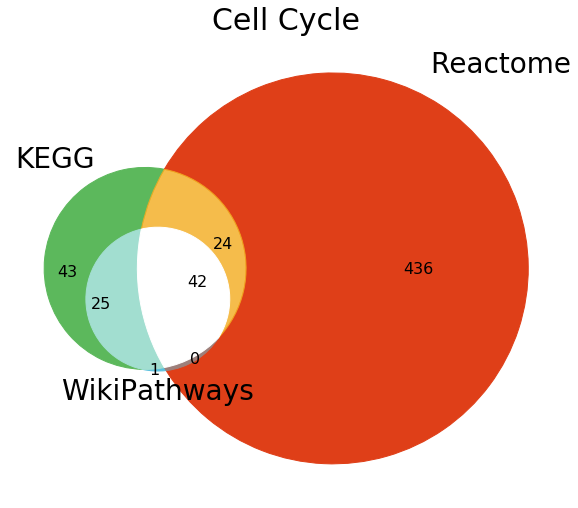

In [11]:
plot_venn_diagram('Cell Cycle', venn_diagram_dict['Cell Cycle'])

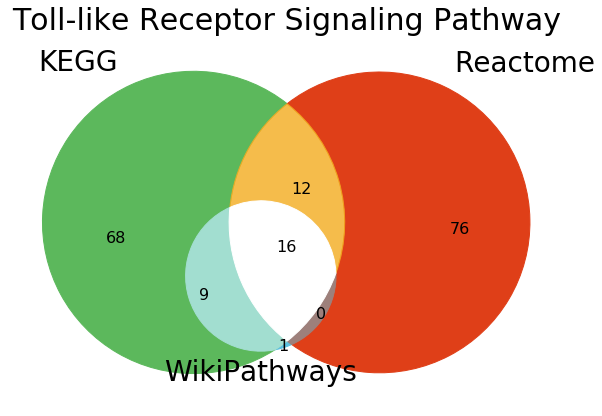

In [12]:
plot_venn_diagram(
    'Toll-like Receptor Signaling Pathway', 
    venn_diagram_dict['Toll-like Receptor Signaling Pathway']
)

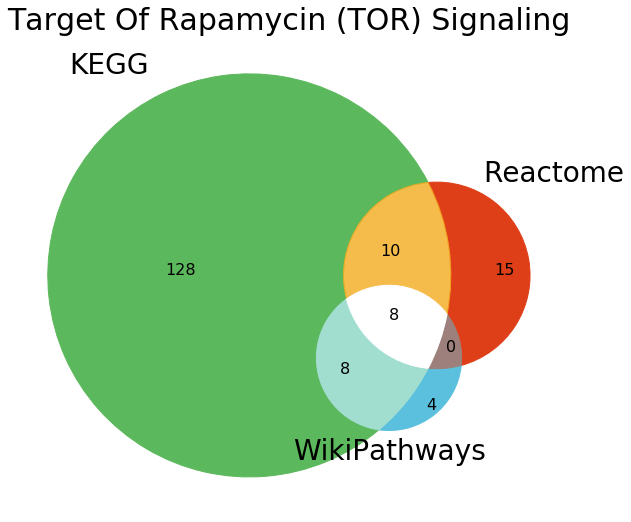

In [13]:
plot_venn_diagram(
    'Target Of Rapamycin (TOR) Signaling',
    venn_diagram_dict['Target Of Rapamycin (TOR) Signaling']
)

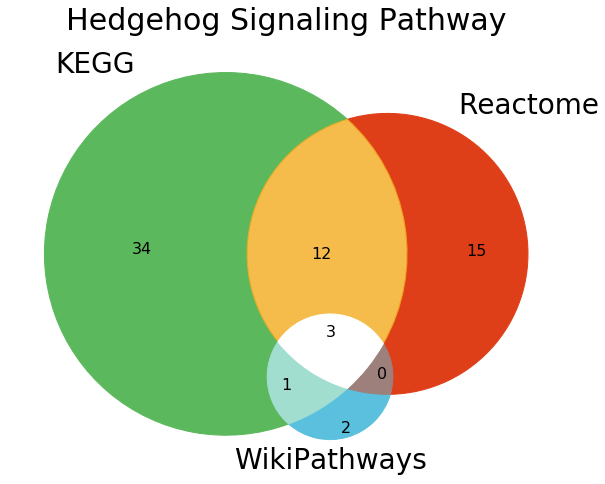

In [14]:
plot_venn_diagram('Hedgehog Signaling Pathway', venn_diagram_dict['Hedgehog Signaling Pathway'])

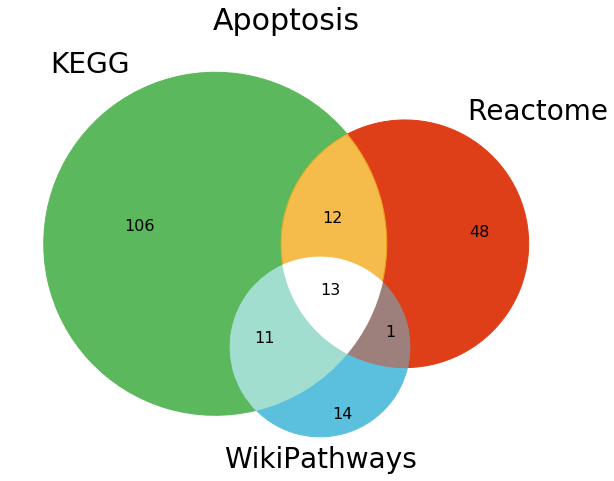

In [15]:
plot_venn_diagram('Apoptosis', venn_diagram_dict['Apoptosis'])

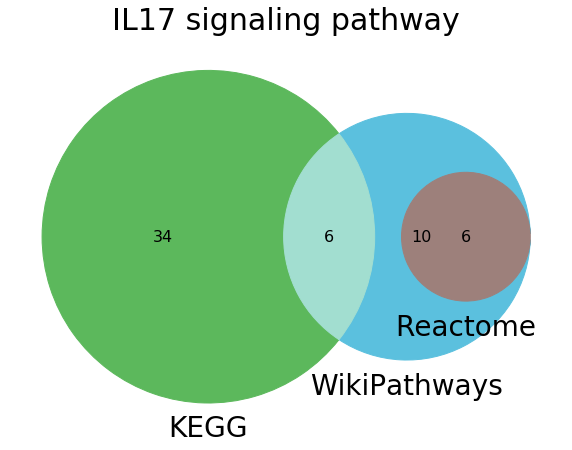

In [16]:
plot_venn_diagram('IL17 signaling pathway', venn_diagram_dict['IL17 signaling pathway'])

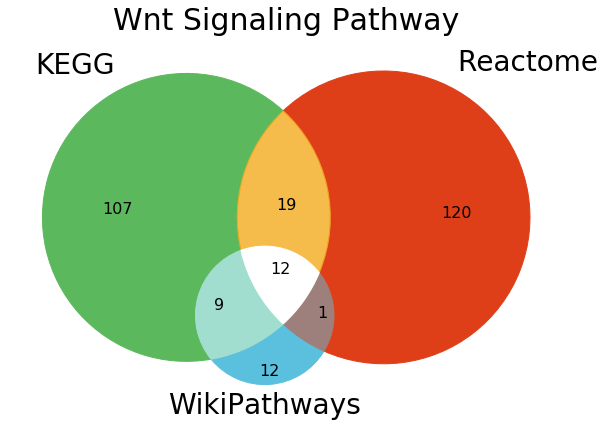

In [17]:
plot_venn_diagram('Wnt Signaling Pathway', venn_diagram_dict['Wnt Signaling Pathway'])

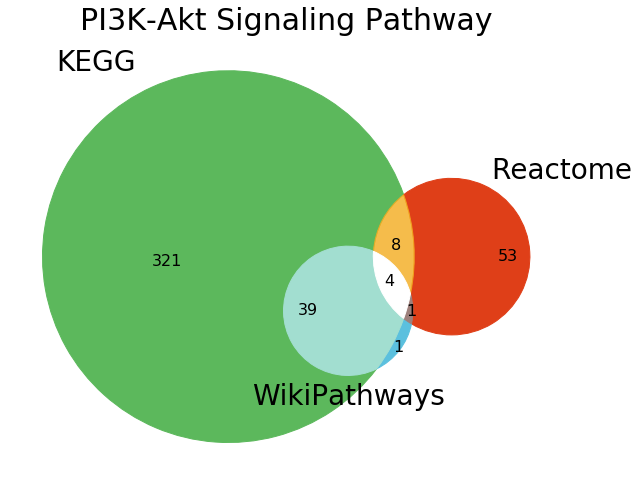

In [18]:
plot_venn_diagram('PI3K-Akt Signaling Pathway', venn_diagram_dict['PI3K-Akt Signaling Pathway'])

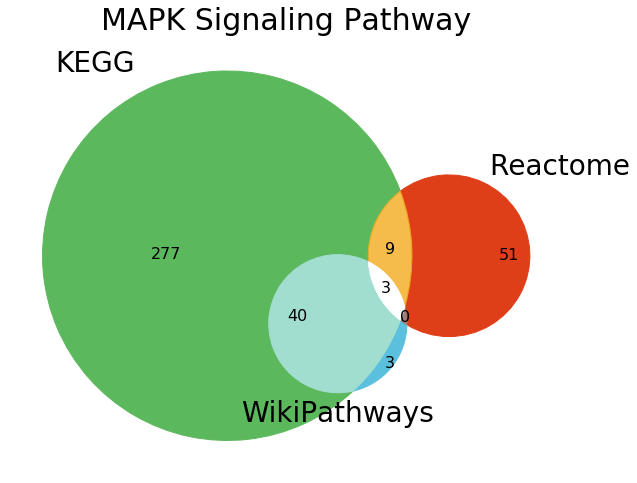

In [19]:
plot_venn_diagram('MAPK Signaling Pathway', venn_diagram_dict['MAPK Signaling Pathway'])

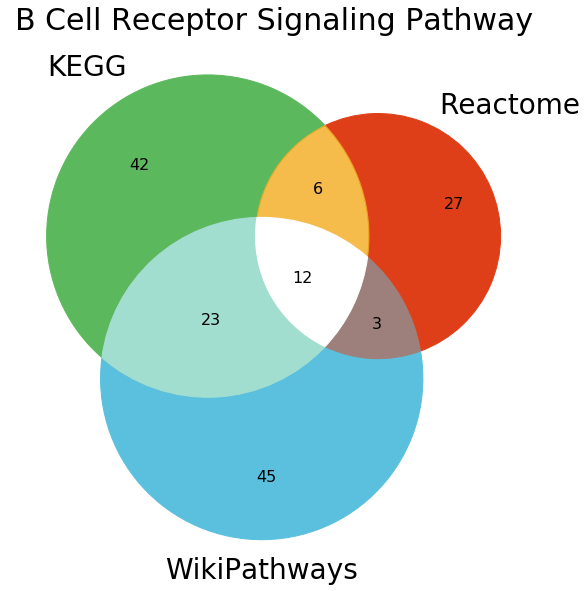

In [20]:
plot_venn_diagram('B Cell Receptor Signaling Pathway', venn_diagram_dict['B Cell Receptor Signaling Pathway'])

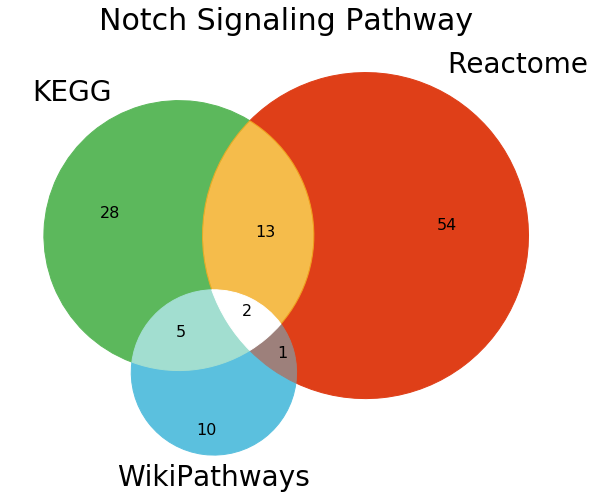

In [21]:
plot_venn_diagram('Notch Signaling Pathway', venn_diagram_dict['Notch Signaling Pathway'])

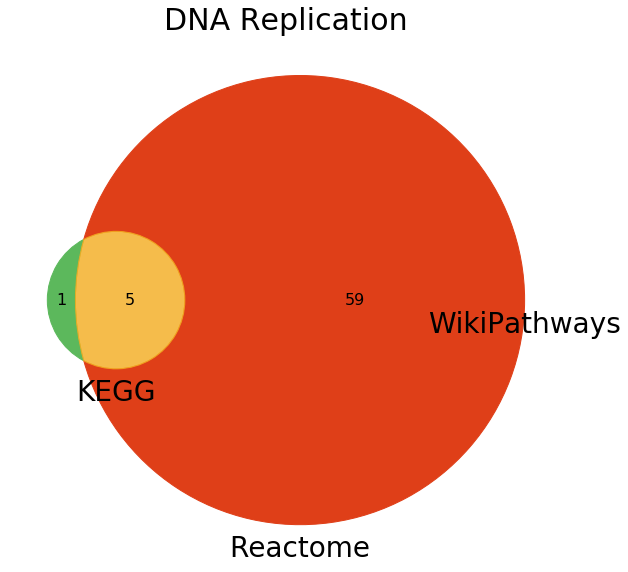

In [22]:
plot_venn_diagram('DNA Replication', venn_diagram_dict['DNA Replication'])

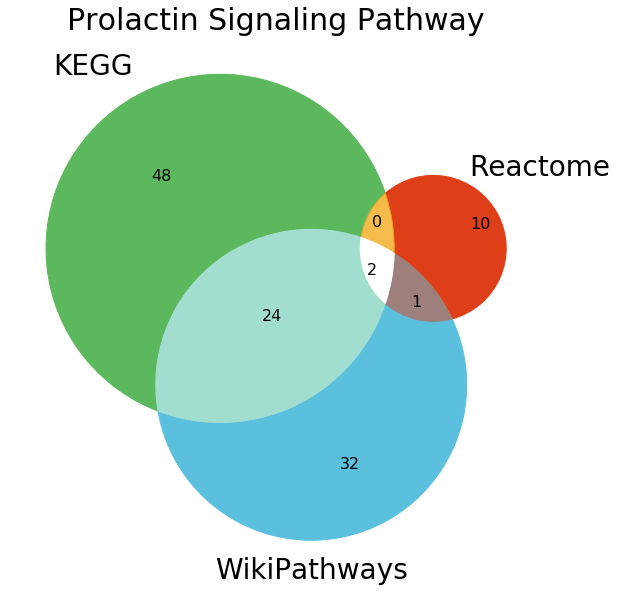

In [23]:
plot_venn_diagram('Prolactin Signaling Pathway', venn_diagram_dict['Prolactin Signaling Pathway'])

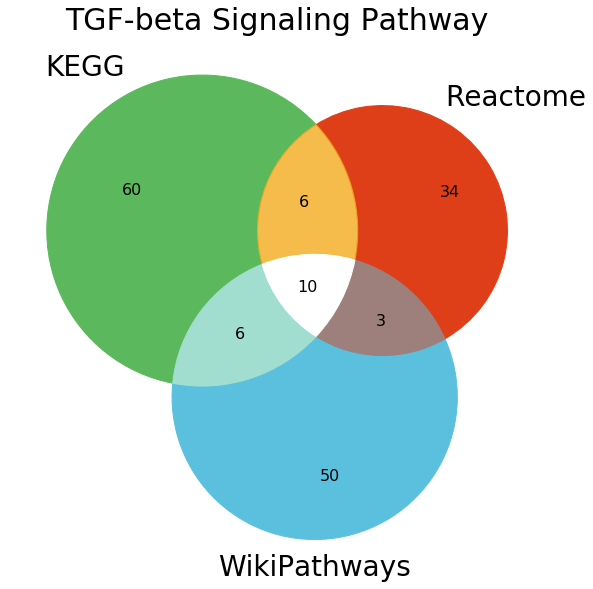

In [24]:
plot_venn_diagram('TGF-beta Signaling Pathway', venn_diagram_dict['TGF-beta Signaling Pathway'])

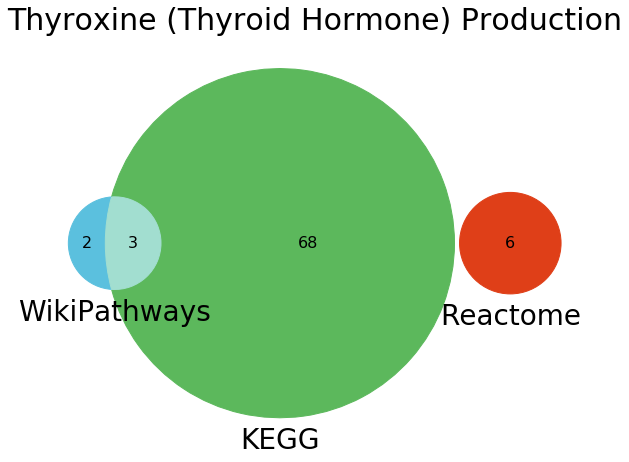

In [25]:
plot_venn_diagram(
    'Thyroxine (Thyroid Hormone) Production', 
    venn_diagram_dict['Thyroxine (Thyroid Hormone) Production']
)

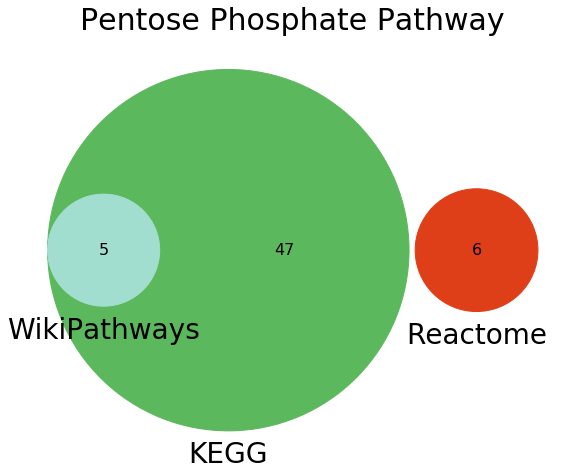

In [26]:
plot_venn_diagram('Pentose Phosphate Pathway', venn_diagram_dict['Pentose Phosphate Pathway'])

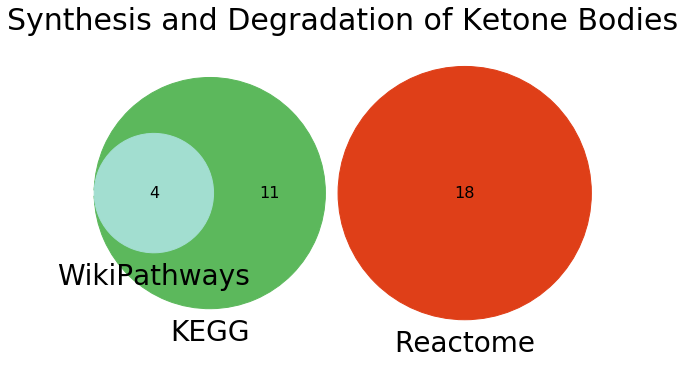

In [27]:
plot_venn_diagram(
    'Synthesis and Degradation of Ketone Bodies',
    venn_diagram_dict['Synthesis and Degradation of Ketone Bodies']
)

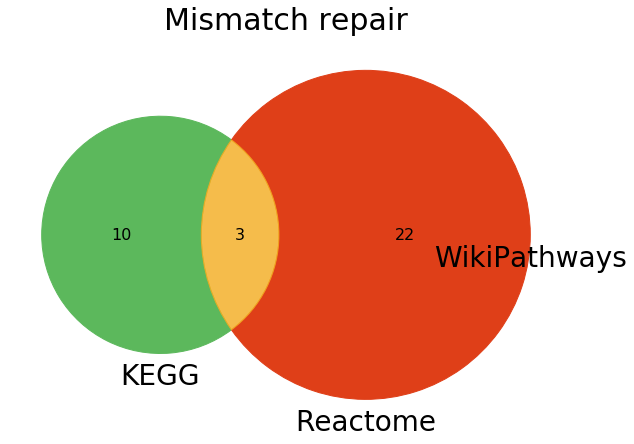

In [28]:
plot_venn_diagram('Mismatch repair', venn_diagram_dict['Mismatch repair'])

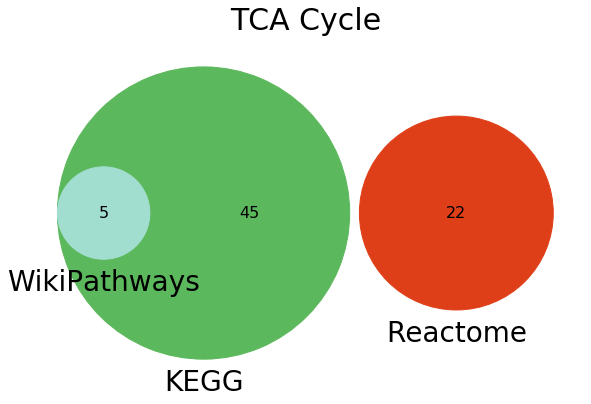

In [29]:
plot_venn_diagram('TCA Cycle', venn_diagram_dict['TCA Cycle'])

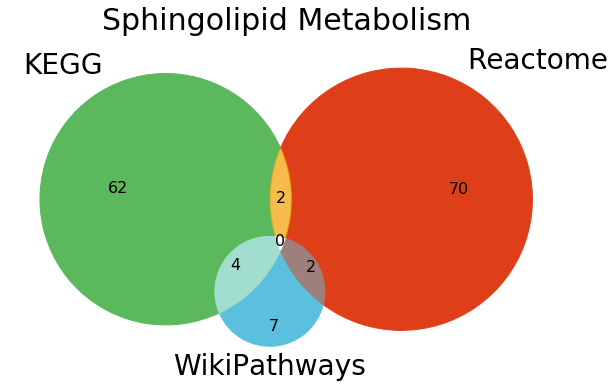

In [30]:
plot_venn_diagram('Sphingolipid Metabolism', venn_diagram_dict['Sphingolipid Metabolism'])

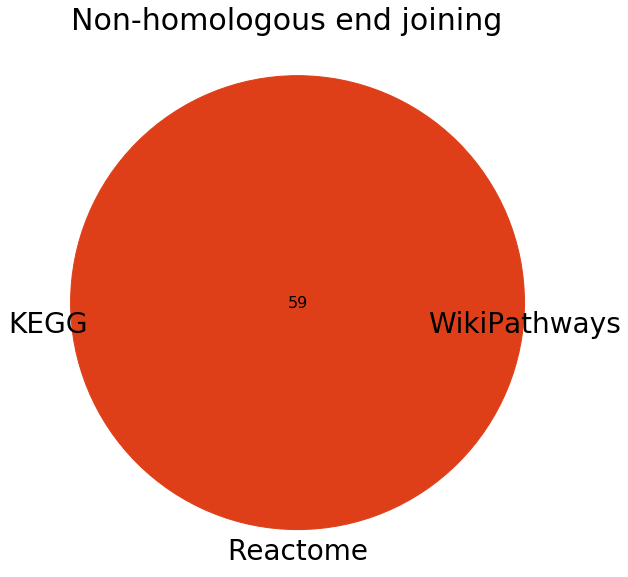

In [31]:
plot_venn_diagram('Non-homologous end joining', venn_diagram_dict['Non-homologous end joining'])